# 패션 데이터셋을 이용한 이미지 분류

- 패션 데이터셋
  - 10가지의 패션 이미지 데이터로 구성
  - 60000개의 데이터
  - 이미지 크기 28 x 28

- Xception 모델을 전이학습

In [1]:
# 할당된 GPU 보기
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17385707969496310728
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14415560704
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 542675902612922548
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [2]:
# 현재 할당된 것이 CPU인지 GPU인지 확인
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 할당된 GPU를 실행
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus :
  try :
    # GPU 메모리 사용을 설|정
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as re :
    print(re)

In [4]:
# GPU 메모리를 전부 할당하지 않고 필요에 따라 자동으로 할당하도록 설정
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config = config)

In [71]:
# 데이터 로드
from tensorflow.keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [72]:
# 훈련데이터 1000개, 테스트데이터 300개만 사용
X_train = X_train[:1000, :]
y_train = y_train[:1000]
X_test = X_test[:300, :]
y_test = y_test[:300]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1000, 28, 28), (1000,), (300, 28, 28), (300,))

In [73]:
# y의 라벨 확인
import pandas as pd

pd.Series(y_train).unique()

array([9, 0, 3, 2, 7, 5, 1, 6, 4, 8], dtype=uint8)

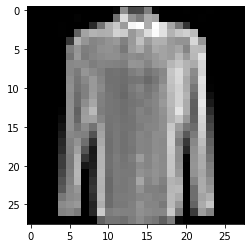

In [74]:
# 이미지 확인
import matplotlib.pyplot as plt
plt.imshow(X_train[140], cmap='gray')

In [75]:
# y를 원핫 인코딩
y_train_en = pd.get_dummies(y_train)
y_test_en = pd.get_dummies(y_test)

y_train_en.shape, y_test_en.shape

((1000, 10), (300, 10))

In [76]:
# 이미지를 (244, 244) 크기로 변환
from PIL import Image
import numpy as np

train_resize_list = []
for i in range(len(X_train)):
  train_resize_img = Image.fromarray(X_train[i]).resize((244,244))
  train_resize_list.append(np.array(train_resize_img))

test_resize_list = []
for i in range(len(X_test)):
  test_resize_img = Image.fromarray(X_test[i]).resize((244,244))
  test_resize_list.append(np.array(test_resize_img))


In [77]:
X_train_resized = np.array(train_resize_list)
X_test_resized = np.array(test_resize_list)

X_train_resized.shape, X_test_resized.shape

((1000, 244, 244), (300, 244, 244))

In [78]:
# 색채널 차원 추가
X_train_resized = X_train_resized.reshape(X_train_resized.shape[0], 244, 244, 1)
X_test_resized = X_test_resized.reshape(X_test_resized.shape[0], 244, 244, 1)

X_train_resized.shape, X_test_resized.shape

((1000, 244, 244, 1), (300, 244, 244, 1))

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout, Activation

In [33]:
# 딥러닝 모델 생성
model1 = Sequential()
# 입력층, 특징추출부
model1.add(Conv2D(
    filters =32, # 특징의 갯수
    kernel_size = (3,3), # 특징의 크기
    input_shape = (244,244,1), # 입력 데이터의 모양
    padding = 'same', # 입력이미지와 출력이미지의 크기를 동일하게
    activation = 'relu'
))
# 특징이 아니라면 삭제하는 기능
model1.add(MaxPool2D(pool_size = (2,2)))
# 입력층, 특징추출부
model1.add(Conv2D(
    filters =64, # 특징의 갯수
    kernel_size = (3,3), # 특징의 크기
    input_shape = (244,244,1), # 입력 데이터의 모양
    padding = 'same', # 입력이미지와 출력이미지의 크기를 동일하게
    activation = 'relu'
))
# 특징이 아니라면 삭제하는 기능
model1.add(MaxPool2D(
    pool_size = (2,2)
))
############################ 특징 추출부 끝 ###########################
model1.add(Flatten()) # 추출된 특징을 1차원으로 바꿔줌
############################ 분류부 시작 ##########################
# 위에서 특징을 추출했기때문에 층을 깊게 쌓지 않아도됨
model1.add(Dense(units=256, activation='relu'))
model1.add(Dense(units=10, activation='softmax'))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 244, 244, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 122, 122, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 238144)            0         
                                                                 
 dense_2 (Dense)             (None, 256)              

In [34]:
model1.compile(
    loss= 'categorical_crossentropy',
    optimizer = 'adam',
    metrics=['accuracy']
)

In [35]:
h1 = model1.fit(X_train_resized, y_train_en, batch_size=20, epochs=10,
                  validation_data=(X_test_resized, y_test_en))

Epoch 1/10
50/50 [==============================] - 6s 120ms/step - loss: 105.2528 - accuracy: 0.6070 - val_loss: 0.7927 - val_accuracy: 0.7433
Epoch 2/10
50/50 [==============================] - 2s 48ms/step - loss: 0.2946 - accuracy: 0.9030 - val_loss: 0.6723 - val_accuracy: 0.8033
Epoch 3/10
50/50 [==============================] - 2s 45ms/step - loss: 0.0875 - accuracy: 0.9690 - val_loss: 0.9510 - val_accuracy: 0.7767
Epoch 4/10
50/50 [==============================] - 2s 47ms/step - loss: 0.0537 - accuracy: 0.9870 - val_loss: 0.8696 - val_accuracy: 0.7833
Epoch 5/10
50/50 [==============================] - 2s 44ms/step - loss: 0.0316 - accuracy: 0.9930 - val_loss: 0.9889 - val_accuracy: 0.8033
Epoch 6/10
50/50 [==============================] - 2s 47ms/step - loss: 0.0218 - accuracy: 0.9950 - val_loss: 1.1975 - val_accuracy: 0.8000
Epoch 7/10
50/50 [==============================] - 3s 51ms/step - loss: 0.0187 - accuracy: 0.9930 - val_loss: 1.1484 - val_accuracy: 0.8067
Epoch 8/10

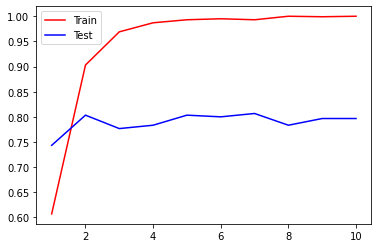

In [37]:
import matplotlib.pyplot as plt

acc = h1.history['accuracy']
val_acc = h1.history['val_accuracy']
e = range(1, len(acc) + 1)

plt.plot(e, acc, "r", label='Train')
plt.plot(e, val_acc, "b", label='Test')
plt.legend()

# Dropout을 이용한 과적합 방지

- Dropout
  - 각 층의 퍼셉트론의 수를 줄여서 과적합을 방지
  - 0.5 이하의 값을 사용
  - 이전층과 다음층의 파라미터의 수가 많이 차이나는 곳에 배치
  

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout, Activation
# 딥러닝 모델 생성
model2 = Sequential()
# 입력층, 특징추출부
model2.add(Conv2D(
    filters =32, # 특징의 갯수
    kernel_size = (3,3), # 특징의 크기
    input_shape = (244,244,1), # 입력 데이터의 모양
    padding = 'same', # 입력이미지와 출력이미지의 크기를 동일하게
    activation = 'relu'
))
# 특징이 아니라면 삭제하는 기능
model2.add(MaxPool2D(pool_size = (2,2)))
# 입력층, 특징추출부
model2.add(Conv2D(
    filters =64, # 특징의 갯수
    kernel_size = (3,3), # 특징의 크기
    input_shape = (244,244,1), # 입력 데이터의 모양
    padding = 'same', # 입력이미지와 출력이미지의 크기를 동일하게
    activation = 'relu'
))
# 특징이 아니라면 삭제하는 기능
model2.add(MaxPool2D(
    pool_size = (2,2)
))
model2.add(Dropout(0.5))
############################ 특징 추출부 끝 ###########################
model2.add(Flatten()) # 추출된 특징을 1차원으로 바꿔줌
############################ 분류부 시작 ##########################
# 위에서 특징을 추출했기때문에 층을 깊게 쌓지 않아도됨
model2.add(Dense(units=256, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(units=264, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(units=10, activation='softmax'))
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 244, 244, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 122, 122, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 61, 61, 64)        0         
                                                                 
 flatten_3 (Flatten)         (None, 238144)           

In [41]:
model2.compile(
    loss= 'categorical_crossentropy',
    optimizer = 'adam',
    metrics=['accuracy']
)

In [42]:
h2 = model2.fit(X_train_resized, y_train_en, batch_size=20, epochs=10,
                  validation_data=(X_test_resized, y_test_en))

Epoch 1/10
50/50 [==============================] - 3s 49ms/step - loss: 52.6602 - accuracy: 0.3300 - val_loss: 1.0482 - val_accuracy: 0.7033
Epoch 2/10
50/50 [==============================] - 2s 48ms/step - loss: 1.0749 - accuracy: 0.6480 - val_loss: 0.7310 - val_accuracy: 0.7967
Epoch 3/10
50/50 [==============================] - 2s 48ms/step - loss: 0.7758 - accuracy: 0.7390 - val_loss: 0.6339 - val_accuracy: 0.7967
Epoch 4/10
50/50 [==============================] - 2s 45ms/step - loss: 0.5600 - accuracy: 0.8250 - val_loss: 0.6027 - val_accuracy: 0.8267
Epoch 5/10
50/50 [==============================] - 2s 45ms/step - loss: 0.4409 - accuracy: 0.8590 - val_loss: 0.5804 - val_accuracy: 0.8367
Epoch 6/10
50/50 [==============================] - 2s 45ms/step - loss: 0.3713 - accuracy: 0.8830 - val_loss: 0.6111 - val_accuracy: 0.8233
Epoch 7/10
50/50 [==============================] - 2s 48ms/step - loss: 0.3222 - accuracy: 0.8900 - val_loss: 0.5378 - val_accuracy: 0.8367
Epoch 8/10
5

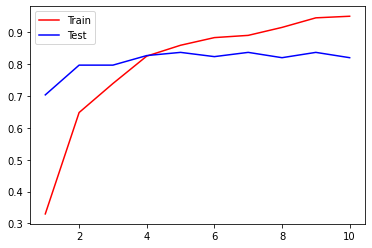

In [43]:
import matplotlib.pyplot as plt

acc = h2.history['accuracy']
val_acc = h2.history['val_accuracy']
e = range(1, len(acc) + 1)

plt.plot(e, acc, "r", label='Train')
plt.plot(e, val_acc, "b", label='Test')
plt.legend()

# BatchNormalization을 이용한 과적합 방지
- CNN 층에서 w, b의 값들을 정규화(일정한 범위의 값으로 변환
- 결과값의 변동폭을 줄여주는 효과

- Conv 층과 Activaction층 사이에 배치
  - Activation 층에 다음에 오면 Activation층이 약간 정규화하는 효과가 있기 때문에 효과가 떨어짐

In [48]:
# 신경망 설계
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
model3 = Sequential()
model3.add(Conv2D(filters=32, kernel_size=(3, 3),
                  input_shape=(244, 244, 1)))
model3.add(BatchNormalization())
model3.add(Activation("relu"))
model3.add(Conv2D(filters=32, kernel_size=(3, 3)))
model3.add(BatchNormalization())
model3.add(Activation("relu"))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Conv2D(filters=64, kernel_size=(3, 3)))
model3.add(Activation("relu"))
model3.add(Conv2D(filters=128, kernel_size=(3, 3)))
model3.add(Activation("relu"))
model3.add(MaxPooling2D(pool_size=(2, 2)))
#model3.add(Dropout(0.5))
# 다차원 데이터를 1차원을 변환
model3.add(Flatten())
# 분류기 모델 설계
model3.add(Dense(units=256, activation="relu"))
model3.add(Dropout(0.5))
model3.add(Dense(units=64, activation="relu"))
model3.add(Dropout(0.2))
model3.add(Dense(units=10, activation="softmax"))
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 242, 242, 32)      320       
                                                                 
 batch_normalization_3 (Batc  (None, 242, 242, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 242, 242, 32)      0         
                                                                 
 conv2d_12 (Conv2D)          (None, 240, 240, 32)      9248      
                                                                 
 batch_normalization_4 (Batc  (None, 240, 240, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 240, 240, 32)     

In [49]:
model3.compile(
    loss= 'categorical_crossentropy',
    optimizer = 'adam',
    metrics=['accuracy']
)

In [50]:
h3 = model3.fit(X_train_resized, y_train_en, batch_size=20, epochs=10,
                  validation_data=(X_test_resized, y_test_en))

Epoch 1/10
50/50 [==============================] - 9s 143ms/step - loss: 4.7543 - accuracy: 0.3690 - val_loss: 1.4399 - val_accuracy: 0.6200
Epoch 2/10
50/50 [==============================] - 6s 123ms/step - loss: 1.0526 - accuracy: 0.6670 - val_loss: 1.2541 - val_accuracy: 0.7467
Epoch 3/10
50/50 [==============================] - 6s 127ms/step - loss: 0.7049 - accuracy: 0.7730 - val_loss: 0.7286 - val_accuracy: 0.7900
Epoch 4/10
50/50 [==============================] - 6s 123ms/step - loss: 0.5343 - accuracy: 0.8230 - val_loss: 0.6781 - val_accuracy: 0.8000
Epoch 5/10
50/50 [==============================] - 6s 124ms/step - loss: 0.4101 - accuracy: 0.8550 - val_loss: 0.6237 - val_accuracy: 0.7867
Epoch 6/10
50/50 [==============================] - 6s 124ms/step - loss: 0.3275 - accuracy: 0.8860 - val_loss: 0.6022 - val_accuracy: 0.8033
Epoch 7/10
50/50 [==============================] - 6s 128ms/step - loss: 0.2611 - accuracy: 0.9210 - val_loss: 0.5540 - val_accuracy: 0.7900
Epoch 

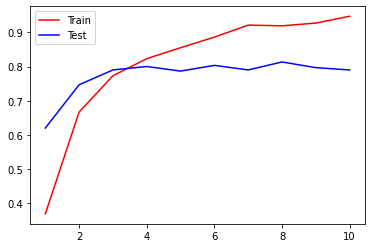

In [51]:
import matplotlib.pyplot as plt

acc = h3.history['accuracy']
val_acc = h3.history['val_accuracy']
e = range(1, len(acc) + 1)

plt.plot(e, acc, "r", label='Train')
plt.plot(e, val_acc, "b", label='Test')
plt.legend()

# GlobalAveragePooling2D을 이용한 과적합 방지
- Flatten() 대신 사용
- 다차원 배열을 1차원으로 만들 때 AveragePoling방법을 사용
  - Flatten()은 4x4를 1x16으로
  - AveragePoling은 평균을 으로 1x4로 만듬

- 근처 특성값들을 평균내서 크기를 줄이는 방식으로 1차원 변환

In [60]:
# w, b의 초기값을 동일하게 하기 위해서 seed 설정 필요
import tensorflow as tf
import numpy as np

seed= 0
np.random.seed(seed)
tf.random.set_seed(seed)

In [56]:
# 신경망 설계
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
model4 = Sequential()
model4.add(Conv2D(filters=32, kernel_size=(3, 3),
                  input_shape=(244, 244, 1)))
model4.add(BatchNormalization())
model4.add(Activation("relu"))
model4.add(Conv2D(filters=32, kernel_size=(3, 3)))
model4.add(BatchNormalization())
model4.add(Activation("relu"))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Conv2D(filters=64, kernel_size=(3, 3)))
model4.add(Activation("relu"))
model4.add(Conv2D(filters=128, kernel_size=(3, 3)))
model4.add(Activation("relu"))
model4.add(MaxPooling2D(pool_size=(2, 2)))
#model3.add(Dropout(0.5))
# 다차원 데이터를 1차원을 변환
model4.add(GlobalAveragePooling2D())
# 분류기 모델 설계
model4.add(Dense(units=256, activation="relu"))
model4.add(Dropout(0.5))
model4.add(Dense(units=64, activation="relu"))
model4.add(Dropout(0.2))
model4.add(Dense(units=10, activation="softmax"))
model4.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 242, 242, 32)      320       
                                                                 
 batch_normalization_11 (Bat  (None, 242, 242, 32)     128       
 chNormalization)                                                
                                                                 
 activation_19 (Activation)  (None, 242, 242, 32)      0         
                                                                 
 conv2d_28 (Conv2D)          (None, 240, 240, 32)      9248      
                                                                 
 batch_normalization_12 (Bat  (None, 240, 240, 32)     128       
 chNormalization)                                                
                                                                 
 activation_20 (Activation)  (None, 240, 240, 32)     

In [59]:
model4.compile(
    loss= 'categorical_crossentropy',
    optimizer = 'adam',
    metrics=['accuracy']
)
h4 = model4.fit(X_train_resized, y_train_en, batch_size=20, epochs=50,
                  validation_data=(X_test_resized, y_test_en))

Epoch 1/50
50/50 [==============================] - 6s 111ms/step - loss: 1.4299 - accuracy: 0.4160 - val_loss: 1.2586 - val_accuracy: 0.5567
Epoch 2/50
50/50 [==============================] - 5s 103ms/step - loss: 1.3351 - accuracy: 0.4620 - val_loss: 1.1399 - val_accuracy: 0.6200
Epoch 3/50
50/50 [==============================] - 5s 103ms/step - loss: 1.3327 - accuracy: 0.4890 - val_loss: 1.1050 - val_accuracy: 0.6000
Epoch 4/50
50/50 [==============================] - 5s 104ms/step - loss: 1.2420 - accuracy: 0.5100 - val_loss: 1.0669 - val_accuracy: 0.5800
Epoch 5/50
50/50 [==============================] - 5s 108ms/step - loss: 1.2125 - accuracy: 0.5360 - val_loss: 1.4547 - val_accuracy: 0.4100
Epoch 6/50
50/50 [==============================] - 5s 105ms/step - loss: 1.1858 - accuracy: 0.5430 - val_loss: 1.2758 - val_accuracy: 0.5133
Epoch 7/50
50/50 [==============================] - 5s 110ms/step - loss: 1.1458 - accuracy: 0.5660 - val_loss: 1.0274 - val_accuracy: 0.6200
Epoch 

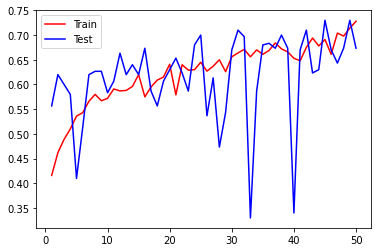

In [61]:
import matplotlib.pyplot as plt

acc = h4.history['accuracy']
val_acc = h4.history['val_accuracy']
e = range(1, len(acc) + 1)

plt.plot(e, acc, "r", label='Train')
plt.plot(e, val_acc, "b", label='Test')
plt.legend()

# Exeption 모델을 이용한 전이학습

In [ ]:
# Exeption 모델 가져오기
from tensorflow.keras.applications import Xception

# include_top : 모델을 가져올때 분류기를 가져올지 여부 (False이면 CNN층만 가져옴)
# weights : 가져올 가중치의 종류(imagenet)
# input_shape() :

pre_trained_model = Xception(include_top = False, weights = 'imagenet', input_shape =  (244,244,3))

pre_trained_model.summary()

In [79]:
X_train_resized.shape, X_test_resized.shape

((1000, 244, 244, 1), (300, 244, 244, 1))

In [80]:
# 1채널인 색상채널을 3채널로 변환
# 3차원 축을 3번 반복해서 저장
X_train_resized = np.repeat(X_train_resized, 3, axis=3)
X_test_resized = np.repeat(X_test_resized, 3, axis=3)
X_train_resized.shape, X_test_resized.shape

((1000, 244, 244, 3), (300, 244, 244, 3))

In [86]:
# 전이학습 모델 설계
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation

model5 = Sequential()

# Xception 모델을 전이학습
model5.add(pre_trained_model)
model5.add(Flatten())

# 우리가 설계한 분류 모델을 추가
model5.add(Dense(units=512, activation="relu"))

model5.add(Dense(units=10, activation="softmax"))

model5.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 flatten_8 (Flatten)         (None, 131072)            0         
                                                                 
 dense_29 (Dense)            (None, 512)               67109376  
                                                                 
 dense_30 (Dense)            (None, 10)                5130      
                                                                 
Total params: 87,975,986
Trainable params: 87,921,458
Non-trainable params: 54,528
_________________________________________________________________


In [87]:
model5.compile(
    loss= 'categorical_crossentropy',
    optimizer = 'adam',
    metrics=['accuracy']
)
h5 = model5.fit(X_train_resized, y_train_en, batch_size=20, epochs=30,
                  validation_data=(X_test_resized, y_test_en))

Epoch 1/30
50/50 [==============================] - 28s 485ms/step - loss: 2.3028 - accuracy: 0.0930 - val_loss: 2.3027 - val_accuracy: 0.1067
Epoch 2/30
50/50 [==============================] - 24s 485ms/step - loss: 2.3022 - accuracy: 0.1090 - val_loss: 2.3027 - val_accuracy: 0.0967
Epoch 3/30
50/50 [==============================] - 23s 455ms/step - loss: 2.3019 - accuracy: 0.1150 - val_loss: 2.3030 - val_accuracy: 0.0967
Epoch 4/30
50/50 [==============================] - 23s 457ms/step - loss: 2.3017 - accuracy: 0.1150 - val_loss: 2.3031 - val_accuracy: 0.0967
Epoch 5/30
50/50 [==============================] - 24s 481ms/step - loss: 2.3014 - accuracy: 0.1150 - val_loss: 2.3034 - val_accuracy: 0.0967
Epoch 6/30
50/50 [==============================] - 23s 456ms/step - loss: 2.3014 - accuracy: 0.1150 - val_loss: 2.3036 - val_accuracy: 0.0967
Epoch 7/30
50/50 [==============================] - 24s 479ms/step - loss: 2.3010 - accuracy: 0.1150 - val_loss: 2.3038 - val_accuracy: 0.0967

KeyboardInterrupt: ignored

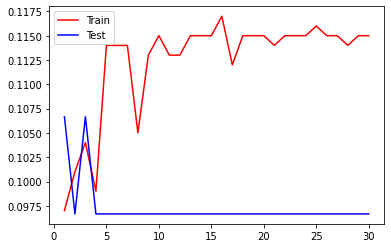

In [83]:
import matplotlib.pyplot as plt

acc = h5.history['accuracy']
val_acc = h5.history['val_accuracy']
e = range(1, len(acc) + 1)

plt.plot(e, acc, "r", label='Train')
plt.plot(e, val_acc, "b", label='Test')
plt.legend()